# Image classification with Celebrity Faces dataset

## Environment setup

In [1]:
# Force no warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
from pathlib import Path
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress INFO and WARNING messages in TensorFlow
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Force TensorFlow to use your GPU1 (NVidia GPU)

In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img, save_img
from keras.utils import set_random_seed
from keras.layers import Input, Resizing, RandomRotation, RandomShear, RandomFlip
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split

In [3]:
# Some utility variables used throughout this experiment
rs = 147 # Random state for repeatability
img_root = "../../data/Celebrity Faces Dataset"
labels = [
    "Angelina Jolie", "Kate Winslet", "Natalie Portman", "Nicole Kidman", "Sandra Bullock",
    "Brad Pitt", "Johnny Depp", "Leonardo DiCaprio", "Tom Cruise", "Tom Hanks"
]
label_map = { labels[idx]: idx for idx in range(len(labels)) }
label_col = "img_label" # Target column name in temporary DataFrame
new_size = (200, 200) # Final image size for preprocessing (MUST be reduced if out of memory)

set_random_seed(rs)

## Utility functions

In [4]:
def images_as_dataframe(img_root, class_names=None):
    rows = []
    for root, dirs, files in os.walk(img_root, topdown=False):
        if len(files):
            img_label = os.path.split(root)[-1]
            if class_names and img_label in class_names:
                for file in files:
                    row = {
                        "img_path": str(Path(f"/{img_label}") / file),
                        "img_label": img_label
                    }
                    rows.append(pd.Series(row))

    return pd.DataFrame(rows)

In [5]:
def train_val_test_split(df, target):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a Pandas DataFrame object.")

    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=50, stratify=y_train, random_state=rs)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [6]:
def aggregate_images(img_root, df, size):
    all_img = []
    for img in df["img_path"]:
        img_path = img_root + img

        # Load image as Numpy array using Keras utilities
        image = load_img(img_path)
        image_arr = img_to_array(image)

        # Resize image to given size using Keras Resizing layer
        in_layer = Input(shape=image_arr.shape)
        res_layer = Resizing(size[0], size[1])(in_layer)
        model = Model(inputs=in_layer, outputs=res_layer)
        res_arr = model(np.array([image_arr])) # Make a single-item batch from original image (i.e., convert 3D tensor to 4D)
        res_arr = res_arr.numpy().reshape((size[0], size[1], 3)) # Convert 4D tensor to 3D numpy array
        all_img.append(res_arr)

    # Return resulting list as an image batch
    return np.array(all_img)

In [7]:
def prepare_data(img_root, X, y, size):
    X_prep = aggregate_images(img_root, X, size)
    y_prep = [label_map[label] for label in y]
    y_prep = np.array(y_prep)

    return X_prep, y_prep

In [8]:
def get_model(in_shape):
    DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal")
    model = Sequential([
        Input(shape=in_shape),
        DefaultConv2D(filters=64, kernel_size=5),
        MaxPool2D(),
        DefaultConv2D(filters=128),
#        DefaultConv2D(filters=128),
        MaxPool2D(),
        DefaultConv2D(filters=256),
#        DefaultConv2D(filters=256),
        MaxPool2D(),
        Flatten(),
        Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(units=10, activation="softmax")
    ])

    return model

## Data preparation

In [9]:
# Make a temporary DataFrame from dataset images
df_images = images_as_dataframe(img_root, labels)
df_images.sample(10, random_state=rs)

,img_path,img_label
942,/Natalie Portman/072_7dbad240.jpg,Natalie Portman
766,/Tom Hanks/095_2939d9c5.jpg,Tom Hanks
419,/Nicole Kidman/074_f13e769d.jpg,Nicole Kidman
441,/Nicole Kidman/082_60cd659d.jpg,Nicole Kidman
437,/Nicole Kidman/063_34aa92fe.jpg,Nicole Kidman
690,/Kate Winslet/028_669aab36.jpg,Kate Winslet
73,/Brad Pitt/039_1c018deb.jpg,Brad Pitt
294,/Tom Cruise/059_6b515be7.jpg,Tom Cruise
524,/Angelina Jolie/019_57ab290d.jpg,Angelina Jolie
319,/Leonardo DiCaprio/090_b316be20.jpg,Leonardo DiCaprio


In [10]:
# Split temporary DataFrame to train/test/validation sets (for later preprocessing)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(df_images, label_col)

print(f"Train shape - X : {X_train.shape}\ty : {y_train.shape}")
print(f"Val shape   - X : {X_val.shape}\ty : {y_val.shape}")
print(f"Test shape  - X : {X_test.shape}\ty : {y_test.shape}")

Train shape - X : (750, 1)	y : (750,)
Val shape   - X : (50, 1)	y : (50,)
Test shape  - X : (200, 1)	y : (200,)


In [11]:
# Resize images in train/validation/test datasets and encode class labels
X_train, y_train = prepare_data(img_root, X_train, y_train, new_size)

I0000 00:00:1767212693.804919    6738 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1353 MB memory:  -> device: 0, name: NVIDIA GeForce MX570 A, pci bus id: 0000:01:00.0, compute capability: 8.6


In [12]:
X_val, y_val = prepare_data(img_root, X_val, y_val, new_size)

In [13]:
X_test, y_test = prepare_data(img_root, X_test, y_test, new_size)

In [14]:
print(f"Train shape - X : {X_train.shape}\ty : {y_train.shape}")
print(f"Val shape   - X : {X_val.shape}\ty : {y_val.shape}")
print(f"Test shape  - X : {X_test.shape}\ty : {y_test.shape}")

Train shape - X : (750, 200, 200, 3)	y : (750,)
Val shape   - X : (50, 200, 200, 3)	y : (50,)
Test shape  - X : (200, 200, 200, 3)	y : (200,)


In [15]:
# Save validation and test sets to compressed Numpy files (.npz)
np.savez_compressed("test.npz", x_test=X_test, y_test=y_test, allow_pickle=False)
np.savez_compressed("validation.npz", x_val=X_val, y_val=y_val, allow_pickle=False)

(np.float64(-0.5), np.float64(199.5), np.float64(199.5), np.float64(-0.5))

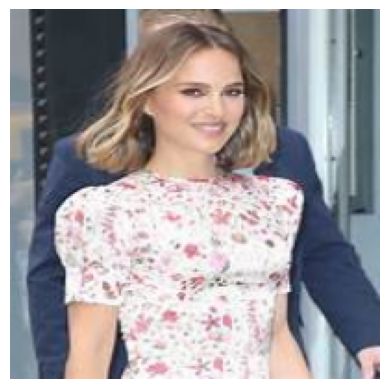

In [16]:
# Preview a sample image
plt.imshow(X_test[7].astype(np.uint8))
plt.axis("off")

In [ ]:
X_train.dtype

## Training a basic CNN on a small training data

In [23]:
model = get_model(X_train.shape[1:])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    20,480,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,862,922 (79.59 MB)

 Trainable params: 20,862,922 (79.59 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
optimizer = SGD(learning_rate=0.003)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [19]:
y_train_q = y_train.astype(np.int8)
y_val_q = y_val.astype(np.int8)
X_train_s, X_val_s = X_train / 255.0, X_val / 255.0

In [25]:
history = model.fit(X_train_s, y_train_q, batch_size=1, epochs=30, validation_data=(X_val_s, y_val_q))

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.0840 - loss: 2.5385 - val_accuracy: 0.1400 - val_loss: 2.2947
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.1213 - loss: 2.2820 - val_accuracy: 0.2000 - val_loss: 2.2581
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.1787 - loss: 2.2276 - val_accuracy: 0.1600 - val_loss: 2.2104
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.1920 - loss: 2.1545 - val_accuracy: 0.2600 - val_loss: 2.0929
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2480 - loss: 2.0875 - val_accuracy: 0.2600 - val_loss: 2.0160
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.2853 - loss: 1.9390 - val_accuracy: 0.2400 - val_loss: 1.9821
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3320 - loss: 1.8812 - val_accuracy: 0.2000 - val_loss: 1.9384
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3720 - loss: 1.7280 - v

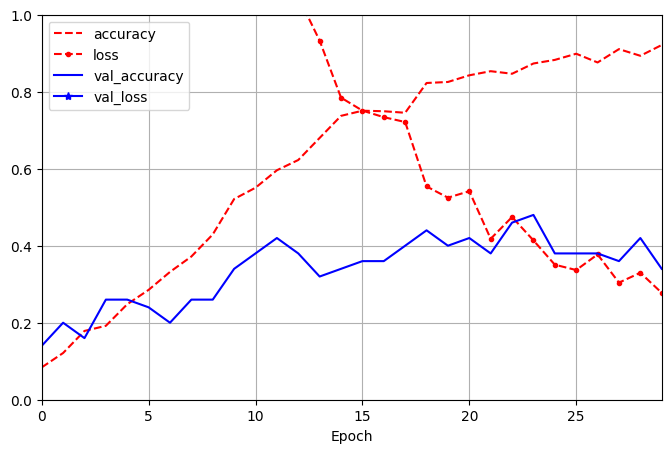

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5), xlim=[0, 29], ylim=[0, 1],
                                   grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()